In [62]:
import glob
import pandas as pd
import numpy as np

In [67]:
df = pd.read_csv('Data_solar.csv')
df[1:23]

,SETTLEMENTDATE,F_all_power,Delta_power
1,1/1/2021 2:00,33391,0
2,1/1/2021 3:00,33391,0
3,1/1/2021 4:00,33391,0
4,1/1/2021 5:00,33391,0
5,1/1/2021 6:00,33391,0
6,1/1/2021 7:00,33391,0
7,1/1/2021 8:00,33391,0
8,1/1/2021 9:00,33395,4
9,1/1/2021 10:00,33407,12
10,1/1/2021 11:00,33459,52


In [42]:
df['Date Time'] = pd.to_datetime(df['SETTLEMENTDATE'])
df['Day'] = df["Date Time"].dt.date
df['Month'] = df['Date Time'].dt.month
df['Year'] = df['Date Time'].dt.year
df['Hour'] = df['Date Time'].dt.hour
df['Minute'] = df['Date Time'].dt.minute
df['Power_gen'] = pd.to_numeric(df['Delta_power'], errors='coerce')
print(df.head())

  SETTLEMENTDATE  F_all_power  Delta_power           Date Time         Day  \
0  1/1/2021 1:00        33391            0 2021-01-01 01:00:00  2021-01-01   
1  1/1/2021 2:00        33391            0 2021-01-01 02:00:00  2021-01-01   
2  1/1/2021 3:00        33391            0 2021-01-01 03:00:00  2021-01-01   
3  1/1/2021 4:00        33391            0 2021-01-01 04:00:00  2021-01-01   
4  1/1/2021 5:00        33391            0 2021-01-01 05:00:00  2021-01-01   

   Month  Year  Hour  Minute  Power_gen  
0      1  2021     1       0          0  
1      1  2021     2       0          0  
2      1  2021     3       0          0  
3      1  2021     4       0          0  
4      1  2021     5       0          0  


In [43]:
print(df.dtypes)

SETTLEMENTDATE            object
F_all_power                int64
Delta_power                int64
Date Time         datetime64[ns]
Day                       object
Month                      int64
Year                       int64
Hour                       int64
Minute                     int64
Power_gen                  int64
dtype: object


In [44]:
df.drop(['F_all_power'], axis=1, inplace=True)
df.drop(['SETTLEMENTDATE'], axis=1, inplace=True)
df.drop(['Date Time'], axis=1, inplace=True)
df.drop(['Delta_power'], axis=1, inplace=True)

In [45]:
df.head()

,Day,Month,Year,Hour,Minute,Power_gen
0,2021-01-01,1,2021,1,0,0
1,2021-01-01,1,2021,2,0,0
2,2021-01-01,1,2021,3,0,0
3,2021-01-01,1,2021,4,0,0
4,2021-01-01,1,2021,5,0,0


In [46]:
X = []
y = []
for i in range (0, df.shape[0]-24):
    X.append(df.iloc[i:i+24, 5])
    y.append(df.iloc[i+24, 5])

X, y = np.array(X), np.array(y)
y = np.reshape(y, (len(y), 1))

X = np.delete(X, list(range(1, X.shape[1], 2)), axis=1)
X = np.delete(X, list(range(1, X.shape[0], 2)), axis=0)
y = np.delete(y, list(range(1, y.shape[0], 2)), axis=0)

pd.DataFrame(X).to_csv('appended_DemandX.csv')
pd.DataFrame(y).to_csv('appended_Demandy.csv')

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test = X[:-240], X[-240:]
y_train, y_test = y[:-240], y[-240:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [48]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6959, 12, 1)
(240, 12, 1)
(6959, 1)
(240, 1)


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [50]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [52]:
import os
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
epochs=150
logdir='logs2'
checkpoint_path = 'checkpoint/cp2.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

In [53]:
filepath = 'model/lstm2.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=50),tensorboard_callback, ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True, mode='min',save_weights_only=True)]
optimizers.Adam(learning_rate=1e-4)

In [54]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_6 (LSTM)               (None, 256)               328704    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 362,113
Trainable params: 362,113
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, callbacks=callbacks, batch_size=8)

Epoch 1/150
696/696 [==============================] - ETA: 0s - loss: 0.0095 - mae: 0.0604 - mape: 12191755.0000
Epoch 1: val_loss improved from inf to 0.00434, saving model to model\lstm2.hdf5
696/696 [==============================] - 17s 15ms/step - loss: 0.0095 - mae: 0.0604 - mape: 12191755.0000 - val_loss: 0.0043 - val_mae: 0.0425 - val_mape: 5703565.5000
Epoch 2/150
691/696 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0423 - mape: 5593769.5000
Epoch 2: val_loss did not improve from 0.00434
696/696 [==============================] - 9s 13ms/step - loss: 0.0050 - mae: 0.0424 - mape: 5638360.0000 - val_loss: 0.0045 - val_mae: 0.0453 - val_mape: 7187852.5000
Epoch 3/150
694/696 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0404 - mape: 5260170.5000
Epoch 3: val_loss improved from 0.00434 to 0.00424, saving model to model\lstm2.hdf5
696/696 [==============================] - 8s 11ms/step - loss: 0.0047 - mae: 0.0404 - mape: 5260247.5000 - v

In [56]:
Loss, MAE, MAPE = model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 6ms/step - loss: 0.0028 - mae: 0.0306 - mape: 2215402.2500


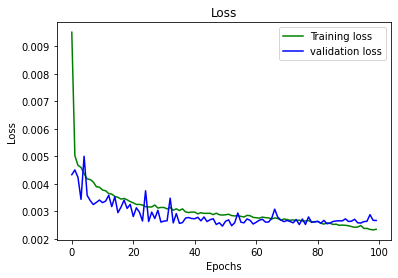

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'b', label='validation loss')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('MSElstm.png', bbox_inches='tight')
plt.show()

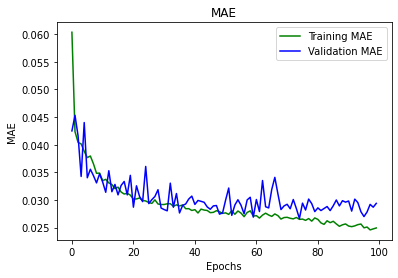

In [58]:
plt.plot(history.epoch, history.history["mae"], 'g', label='Training MAE')
plt.plot(history.epoch, history.history["val_mae"], 'b', label='Validation MAE')

plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.savefig('MAE.png', bbox_inches='tight')
plt.show()

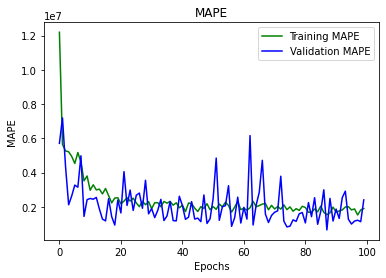

In [59]:
plt.plot(history.epoch, history.history["mape"], 'g', label='Training MAPE')
plt.plot(history.epoch, history.history["val_mape"], 'b', label='Validation MAPE')

plt.title('MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.savefig('MAPE.png', bbox_inches='tight')
plt.show()

In [71]:
import time

for i in range (0, X_test.shape[0]):
    power_summary = []
    X_input = X_test[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], 1))
    X_input = model.predict(X_input)
    forecast = scaler.inverse_transform(X_input)

    y_input = y_test[i,:]
    y_input = np.reshape(y_input, (1,1))
    actual = scaler.inverse_transform(y_input)
    
    power_summary.append(actual)
    power_summary.extend(forecast)

    df_animate = pd.DataFrame(power_summary)
    df_animate = df_animate.T
    df_animate.to_csv('real_time_power.csv', mode='a', header=False, index=False)

    print(power_summary)
    time.sleep(0.1)

1/1 [==============================] - 0s 54ms/step
[array([[0.]]), array([0.70406324], dtype=float32)]
1/1 [==============================] - 0s 30ms/step
[array([[0.]]), array([0.64158404], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 33ms/step
[array([[0.]]), array([0.7867786], dtype=float32)]
1/1 [==============================] - 0s 28ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[1.]]), array([3.300692], dtype=float32)]
1/1 [==============================] - 0s 27ms/step
[array([[11.]]), array([8.890792], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 34ms/step
[array([[16.]]), array([39.910717], dtype=float32)]
1/1 [==============================] - 0s 23ms/step
[array([[35.]]), array([27.144064], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 21ms/step
[array([[16.]]), array([32.3439], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[12.]]), array([7.179459], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 23ms/step
[array([[2.]]), array([2.7311354], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[0.]]), array([0.5198189], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 35ms/step
[array([[0.]]), array([0.65452635], dtype=float32)]
1/1 [==============================] - 0s 24ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.64562714], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[0.]]), array([0.6714725], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[0.]]), array([0.58199316], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 22ms/step
[array([[2.]]), array([1.9277836], dtype=float32)]
1/1 [==============================] - 0s 21ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[8.]]), array([8.85523], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[11.]]), array([20.130228], dtype=float32)]
1/1 [==============================] - 0s 25ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[10.]]), array([28.671415], dtype=float32)]
1/1 [==============================] - 0s 20ms/step
[array([[19.]]), array([15.046977], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[10.]]), array([8.359798], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 24ms/step
[array([[2.]]), array([2.5597942], dtype=float32)]
1/1 [==============================] - 0s 23ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.6155875], dtype=float32)]
1/1 [==============================] - 0s 41ms/step
[array([[0.]]), array([0.55593187], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[0.]]), array([0.6401001], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 21ms/step
[array([[0.]]), array([0.62983936], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[0.]]), array([1.0147359], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 21ms/step
[array([[2.]]), array([0.57543945], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[26.]]), array([18.403326], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 33ms/step
[array([[65.]]), array([55.57662], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[74.]]), array([78.699066], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 20ms/step
[array([[68.]]), array([60.149925], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[31.]]), array([30.73922], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 21ms/step
[array([[4.]]), array([2.814635], dtype=float32)]
1/1 [==============================] - 0s 23ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.73804206], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[0.]]), array([0.6954273], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[0.]]), array([0.6850719], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 22ms/step
[array([[0.]]), array([0.7520641], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[0.]]), array([0.7312066], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 21ms/step
[array([[6.]]), array([1.2659991], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[25.]]), array([37.97605], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 64ms/step
[array([[44.]]), array([43.834686], dtype=float32)]
1/1 [==============================] - 0s 29ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[52.]]), array([51.522697], dtype=float32)]
1/1 [==============================] - 0s 32ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[21.]]), array([37.40324], dtype=float32)]
1/1 [==============================] - 0s 30ms/step
[array([[8.]]), array([13.787834], dtype=float32)]
1/1 [==============================] - 0s 27ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([2.4041042], dtype=float32)]
1/1 [==============================] - 0s 45ms/step
[array([[0.]]), array([0.6225015], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 37ms/step
[array([[0.]]), array([0.68563426], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 31ms/step
[array([[0.]]), array([0.6699943], dtype=float32)]
1/1 [==============================] - 0s 25ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.55954766], dtype=float32)]
1/1 [==============================] - 0s 26ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.71156967], dtype=float32)]
1/1 [==============================] - 0s 45ms/step
[array([[5.]]), array([9.981197], dtype=float32)]
1/1 [==============================] - 0s 30ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[24.]]), array([14.364128], dtype=float32)]
1/1 [==============================] - 0s 39ms/step
[array([[52.]]), array([34.973385], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 25ms/step
[array([[63.]]), array([44.161858], dtype=float32)]
1/1 [==============================] - 0s 28ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[38.]]), array([43.9525], dtype=float32)]
1/1 [==============================] - 0s 25ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[22.]]), array([11.071461], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 31ms/step
[array([[1.]]), array([2.0308578], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 36ms/step
[array([[0.]]), array([0.36065882], dtype=float32)]
1/1 [==============================] - 0s 27ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.7739229], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 36ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.78487545], dtype=float32)]
1/1 [==============================] - 0s 43ms/step
[array([[0.]]), array([0.6558151], dtype=float32)]
1/1 [==============================] - 0s 25ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.6271347], dtype=float32)]
1/1 [==============================] - 0s 43ms/step
[array([[4.]]), array([4.9101176], dtype=float32)]
1/1 [==============================] - 0s 24ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[18.]]), array([16.446558], dtype=float32)]
1/1 [==============================] - 0s 61ms/step
[array([[53.]]), array([31.132774], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 40ms/step
[array([[67.]]), array([54.16618], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 29ms/step
[array([[38.]]), array([47.891968], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 33ms/step
[array([[23.]]), array([17.645388], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 41ms/step
[array([[2.]]), array([2.2825146], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 38ms/step
[array([[0.]]), array([0.3347477], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 40ms/step
[array([[0.]]), array([0.71543723], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 31ms/step
[array([[0.]]), array([0.737758], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 25ms/step
[array([[0.]]), array([0.63940144], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 27ms/step
[array([[0.]]), array([0.59918296], dtype=float32)]
1/1 [==============================] - 0s 22ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([3.0510733], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[2.]]), array([8.14076], dtype=float32)]
1/1 [==============================] - 0s 42ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[14.]]), array([18.852345], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 31ms/step
[array([[12.]]), array([31.582624], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[13.]]), array([11.823679], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 35ms/step
[array([[6.]]), array([8.499544], dtype=float32)]
1/1 [==============================] - 0s 24ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([1.1533514], dtype=float32)]
1/1 [==============================] - 0s 74ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.44862533], dtype=float32)]
1/1 [==============================] - 0s 35ms/step
[array([[0.]]), array([0.6435658], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 32ms/step
[array([[0.]]), array([0.5965892], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[0.]]), array([0.6076237], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 20ms/step
[array([[0.]]), array([0.9019612], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 30ms/step
[array([[3.]]), array([2.685913], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 53ms/step
[array([[21.]]), array([26.741907], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 42ms/step
[array([[32.]]), array([47.941586], dtype=float32)]
1/1 [==============================] - 0s 27ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[24.]]), array([43.40592], dtype=float32)]
1/1 [==============================] - 0s 27ms/step
[array([[28.]]), array([14.438442], dtype=float32)]
1/1 [==============================] - 0s 28ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[24.]]), array([6.776742], dtype=float32)]
1/1 [==============================] - 0s 93ms/step
[array([[2.]]), array([4.1678486], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 53ms/step
[array([[0.]]), array([0.61662334], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 54ms/step
[array([[0.]]), array([1.0786136], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 35ms/step
[array([[0.]]), array([0.91975266], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 44ms/step
[array([[0.]]), array([0.79261637], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 38ms/step
[array([[0.]]), array([0.6678405], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 34ms/step
[array([[3.]]), array([2.5884712], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 30ms/step
[array([[27.]]), array([12.370888], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 29ms/step
[array([[63.]]), array([48.169003], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 41ms/step
[array([[74.]]), array([68.63859], dtype=float32)]
1/1 [==============================] - 0s 25ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[64.]]), array([56.91134], dtype=float32)]
1/1 [==============================] - 0s 27ms/step
[array([[35.]]), array([28.226686], dtype=float32)]
1/1 [==============================] - 0s 27ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[3.]]), array([4.308385], dtype=float32)]
1/1 [==============================] - 0s 66ms/step
[array([[0.]]), array([0.56881297], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 31ms/step
[array([[0.]]), array([0.77143544], dtype=float32)]
1/1 [==============================] - 0s 24ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.77401763], dtype=float32)]
1/1 [==============================] - 0s 27ms/step
[array([[0.]]), array([0.75917447], dtype=float32)]
1/1 [==============================] - 0s 23ms/step
[array([[0.]]), array([0.7108929], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 88ms/step
[array([[5.]]), array([1.7714679], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 29ms/step
[array([[36.]]), array([28.610231], dtype=float32)]
1/1 [==============================] - 0s 30ms/step
[array([[67.]]), array([59.50481], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 59ms/step
[array([[71.]]), array([68.04892], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 46ms/step
[array([[38.]]), array([53.07006], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 44ms/step
[array([[15.]]), array([22.855705], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 37ms/step
[array([[2.]]), array([2.2694154], dtype=float32)]
1/1 [==============================] - 0s 25ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.5495745], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[0.]]), array([0.5665125], dtype=float32)]
1/1 [==============================] - 0s 20ms/step
[array([[0.]]), array([0.6021082], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 22ms/step
[array([[0.]]), array([0.6584759], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 37ms/step
[array([[0.]]), array([0.6796568], dtype=float32)]
1/1 [==============================] - 0s 27ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[2.]]), array([5.2683225], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[1.]]), array([18.899122], dtype=float32)]
1/1 [==============================] - 0s 28ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[10.]]), array([7.4512935], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[16.]]), array([41.630863], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 84ms/step
[array([[15.]]), array([17.048532], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 46ms/step
[array([[2.]]), array([10.582908], dtype=float32)]
1/1 [==============================] - 0s 28ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[1.]]), array([1.7884048], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 31ms/step
[array([[0.]]), array([0.7836733], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 32ms/step
[array([[0.]]), array([0.70980275], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 30ms/step
[array([[0.]]), array([0.66264373], dtype=float32)]
1/1 [==============================] - 0s 23ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[0.]]), array([0.58311796], dtype=float32)]
1/1 [==============================] - 0s 22ms/step
[array([[0.]]), array([1.1498708], dtype=float32)]
1/1 [==============================] - 0s 20ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[3.]]), array([3.330412], dtype=float32)]
1/1 [==============================] - 0s 21ms/step
[array([[26.]]), array([33.93193], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 52ms/step
[array([[72.]]), array([51.681602], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 28ms/step
[array([[73.]]), array([68.525314], dtype=float32)]
1/1 [==============================] - 0s 30ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[67.]]), array([41.561832], dtype=float32)]
1/1 [==============================] - 0s 31ms/step
[array([[35.]]), array([29.1112], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 78ms/step
[array([[2.]]), array([3.216056], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 43ms/step
[array([[0.]]), array([0.5653831], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 27ms/step
[array([[0.]]), array([0.82469547], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 29ms/step
[array([[0.]]), array([0.7833811], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 62ms/step
[array([[0.]]), array([0.74580026], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[0.]]), array([0.6873423], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 32ms/step
[array([[2.]]), array([1.7262686], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 29ms/step
[array([[39.]]), array([21.37406], dtype=float32)]
1/1 [==============================] - 0s 24ms/step
[array([[72.]]), array([65.90454], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 35ms/step
[array([[78.]]), array([74.09182], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 40ms/step
[array([[49.]]), array([63.912144], dtype=float32)]
1/1 [==============================] - 0s 23ms/step


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


[array([[30.]]), array([22.264402], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 36ms/step
[array([[4.]]), array([3.7672567], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 36ms/step
[array([[0.]]), array([0.36727607], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 42ms/step
[array([[0.]]), array([0.595976], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 50ms/step
[array([[0.]]), array([0.66502845], dtype=float32)]


c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 35ms/step
[array([[0.]]), array([0.87922585], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 28ms/step
[array([[0.]]), array([0.9229389], dtype=float32)]
1/1 [==============================] - ETA: 0s

c:\Users\Radityo Fajar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


1/1 [==============================] - 0s 32ms/step


KeyboardInterrupt: 